# # PyTorch Neural Network with Overfitting Prevention
#
# **Key Features**:
# - 200 input features
# - Customizable hidden layers
# - Built-in regularization (Dropout + L2 Weight Decay)
# - Early Stopping
# - Batch Normalization

In [5]:
# ## 1. Setup & Imports

# %%
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np


In [8]:
# ## 2. Neural Network Architecture

# %%
class CustomNet(nn.Module):
    def __init__(self, input_size=200, hidden_sizes=[128, 64], output_size=10, dropout_rate=0.3):
        super().__init__()

        layers = []
        prev_size = input_size

        # Dynamically create hidden layers
        for i, h_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, h_size))
            layers.append(nn.BatchNorm1d(h_size))  # BatchNorm
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Dropout
            prev_size = h_size

        self.hidden = nn.Sequential(*layers)
        self.output = nn.Linear(prev_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        return self.output(x)


In [9]:
# ## 3. Data Preparation

# %%
# Generate synthetic data
input_size = 2000
output_size = 10
samples = 1000  # More samples help prevent overfitting

X = torch.randn(samples, input_size)
y = torch.randint(0, output_size, (samples,))

print(np.shape(X))
print(np.shape(y))


# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


torch.Size([1000, 2000])
torch.Size([1000])


In [10]:
# ## 4. Training Setup

# %%
# Initialize model with L2 regularization (weight decay)
model = CustomNet(input_size=input_size,
                 hidden_sizes=[128, 64, 32],  # 3 hidden layers
                 output_size=output_size,
                 dropout_rate=0.3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

In [11]:
# ## 5. Training Loop with Early Stopping

# %%
epochs = 100
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Progress report
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


Epoch 10/100 | Train Loss: 1.9059 | Val Loss: 2.3138
Early stopping at epoch 14


In [12]:
# ## 6. Model Evaluation

# %%
# Final validation accuracy
model.eval()
with torch.no_grad():
    _, preds = torch.max(model(X_val), 1)
    accuracy = (preds == y_val).float().mean()

print(f"\nFinal Validation Accuracy: {accuracy.item()*100:.2f}%")


Final Validation Accuracy: 12.50%


In [13]:
# ## 7. Prediction Example

# %%
# Generate 5 new samples
test_samples = 5
X_test = torch.randn(test_samples, input_size)

# Predict
model.eval()
with torch.no_grad():
    logits = model(X_test)
    probabilities = torch.softmax(logits, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)

print("\nTest Predictions:")
for i in range(test_samples):
    print(f"Sample {i+1}: Predicted Class {predicted_classes[i].item()} with Confidence {torch.max(probabilities[i]).item():.2f}")




Test Predictions:
Sample 1: Predicted Class 0 with Confidence 0.12
Sample 2: Predicted Class 7 with Confidence 0.12
Sample 3: Predicted Class 2 with Confidence 0.11
Sample 4: Predicted Class 0 with Confidence 0.11
Sample 5: Predicted Class 4 with Confidence 0.12


New attempt

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Generate sample dataset
def generate_dataset(num_samples, seq_length, num_letters):
    data = []
    labels = []
    for _ in range(num_samples):
        # Generate random sequence of letters
        sequence = ''.join(np.random.choice(list('atgcAT'), size=seq_length))

        # Assign probability based on some criteria (example)
        # You should replace this with your actual logic
        probability = np.random.rand()
        if sequence[seq_length // 2] == 'a':  # Example: higher probability if center letter is 'a'
            probability += 0.2
        probability = np.clip(probability, 0, 1)  # Ensure probability is in [0, 1]

        data.append(sequence)
        labels.append(probability)

    return data, labels

# Define the dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, seq_length, num_letters):
        self.data = data
        self.labels = labels
        self.seq_length = seq_length
        self.num_letters = num_letters
        self.letter_to_index = {letter: index for index, letter in enumerate(list('atgcAT'))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        label = self.labels[idx]

        # One-hot encoding for letters
        sequence_encoded = torch.zeros(self.seq_length, self.num_letters)
        for i, letter in enumerate(sequence):
            sequence_encoded[i, self.letter_to_index[letter]] = 1

        return sequence_encoded, torch.tensor([label], dtype=torch.float32)

# Define the CNN model
class TimeSeriesModel(nn.Module):
    def __init__(self, embedding_dim, num_filters, kernel_size, output_size, num_letters):
        super(TimeSeriesModel, self).__init__()
        self.embedding = nn.Embedding(num_letters, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.fc_input_size = (seq_length - kernel_size + 1) * num_filters
        self.fc = nn.Linear(self.fc_input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert one-hot encoded input to indices for embedding layer
        x = torch.argmax(x, dim=-1)  # Get indices of the maximum values along the last dimension
        x = self.embedding(x)  #removed .long()
        x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, embedding_dim, seq_length)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Generate sample data
num_samples = 1000
seq_length = 200
num_letters = 6
data, labels = generate_dataset(num_samples, seq_length, num_letters)

# Create dataset
dataset = TimeSeriesDataset(data, labels, seq_length, num_letters)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset)) # 80% for training
val_size = len(dataset) - train_size # Remaining for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False) # No need to shuffle validation data


# Model parameters
embedding_dim = 10
num_filters = 32
kernel_size = 5
output_size = 1

# Instantiate model, optimizer, and loss function
model = TimeSeriesModel(embedding_dim, num_filters, kernel_size, output_size, num_letters)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Or other suitable loss function

# Training loop with validation
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    for i, (inputs, targets) in enumerate(train_dataloader):
        # ... (Forward pass, backward and optimize remain the same)

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

print("Training finished!")

NameError: name 'random_split' is not defined

In [29]:
import numpy as np
import math, re, random, csv
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from pylab import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg


def display_plot(y, xlim=None):
    x = range(len(y))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom=0.2)
    plt.plot(x,y)
    if xlim:
      plt.xlim(xlim)
    plt.show()
    return


def clean_sequence(dna):
    dna = dna.upper()                 # uppercase
    dna = dna.replace('U','T')        # use T instead of U (in case we get RNA)
    dna = re.sub(r'[^GATC]','', dna)  # remove every character (including whitespace) that is not G, A, T, or C
    return dna

def base2index(base):
    return {'A': 0, 'C': 1, 'G': 2, 'T': 3}.get(base)

def get_weight(w, p, b):
    x = np.arange(w)
    base_probs = {
        'A': 0.25 + b * np.sin(2 * np.pi * x / p),
        'C': 0.25 - b * np.sin(2 * np.pi * x / p) / 3,
        'G': 0.25 - b * np.sin(2 * np.pi * x / p) / 3,
        'T': 0.25 - b * np.sin(2 * np.pi * x / p) / 3
    }
    return [[base_probs[base1][i] for base1 in 'ACGT'] for i in x]


def calculate_energy(seq, w, B, p):
    prob_array = get_weight(w, p, B)
    p_f = []
    p_r = []
    for i in range(len(seq) - w):
        p_s_f = 1.
        p_s_r = 1.
        for s in range(w):
            p_s_f *= prob_array[s][base2index(seq[i + s])]
            p_s_r *= prob_array[s][3 - base2index(seq[i + w - s -1])]
        p_f.append(p_s_f)
        p_r.append(p_s_r)
    p_f = np.array(p_f) * (4**w)
    p_r = np.array(p_r) * (4**w)
    p_r = np.roll(p_r, -1)
    E = (p_r * np.log(p_r) + p_f * np.log(p_f)) / (p_r + p_f)
    return E

def smooth(x,window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w=np.ones(window_len,'d')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[len(x[window_len-1:0:-1]):len(x[window_len-1:0:-1])+len(x)+1]

def vanderlick(Energy, mu):
    E_out = Energy - mu
    footprint = 147

    forward = np.zeros(len(Energy))
    for i in range( len(Energy) ):
        tmp = sum(forward[ max( i - footprint , 0):i])
        forward[i] = np.exp(E_out[i] - tmp)

    backward = np.zeros(len(Energy))
    r_forward = forward[::-1]
    for i in range( len(Energy) ):
        backward[i] = 1 - sum(r_forward[max(i - footprint , 0):i]* backward[max(i - footprint,0):i])

    P = forward * backward[::-1]
    return P

def create_dna(dnalength):
    dna601 = 'ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG'
    if dnalength < len(dna601):
        return dna601[:dnalength]  # Return a truncated version if dnalength is too short

    dna = ''.join(random.choice('ACGT') for _ in range(dnalength))
    start_index = (dnalength - len(dna601)) // 2
    dna = list(dna)
    dna[start_index:start_index + len(dna601)] = list(dna601)
    dna = "".join(dna)
    dna = clean_sequence(dna)
    return dna

def calc_nucleosome_positions(dna, w, mu, B, period):
    energy_nucleosome = calculate_energy(dna, w, B, period)
    energy_smoothed = smooth(energy_nucleosome,10)
    probability = vanderlick(energy_smoothed, mu)
    probability = np.concatenate(  (np.zeros(math.ceil(w//2)), probability,  np.zeros(w//2) ) )
    occupancy = np.convolve(probability, np.ones(146), mode = 'same')
    return energy_nucleosome, energy_smoothed, probability, occupancy



3000


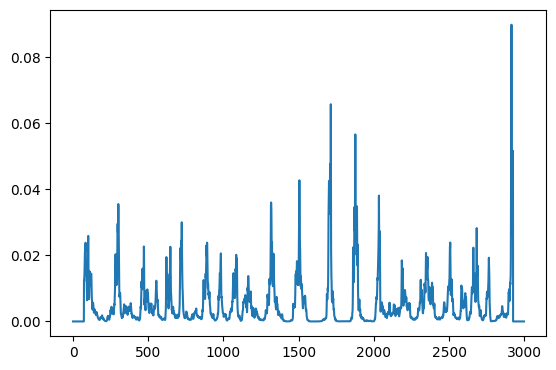

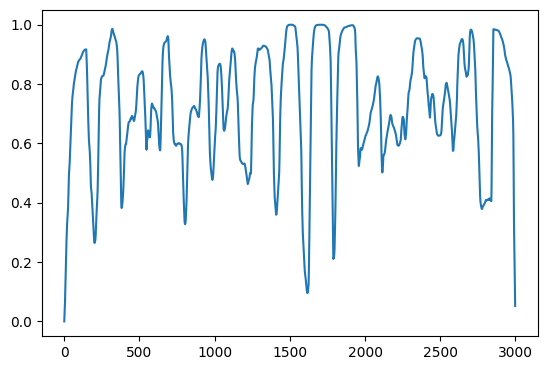

In [60]:
w = 147
mu = -6.5
B = 0.2
period = 10.1

dna = create_dna(3000)

_, _, probability, occupacy = calc_nucleosome_positions(dna, w, mu, B, period)
print(len(dna))

seq_length = 1000
i = np.random.randint(seq_length//2, len(dna)-seq_length//2)
i = len(dna)//2
display_plot(probability) #, [i -seq_length//2, i+seq_length//2])
display_plot(occupacy)#, [i -seq_length//2, i+seq_length//2])
# print(extract_dna(dna, i, 200, res[2]))


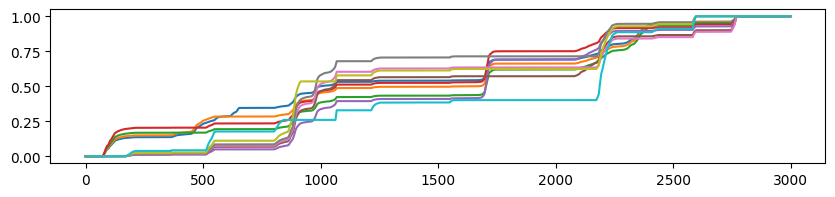

[344  94  89 294  74 724 386 237 432]


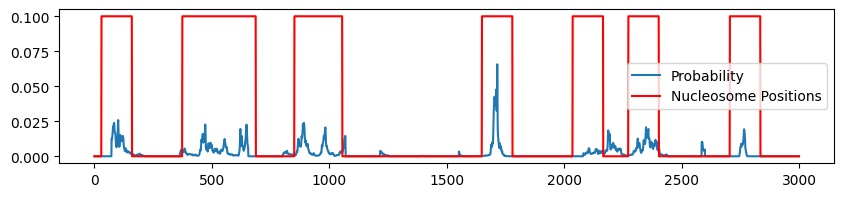

In [447]:
def get_single_fiber(probability, w = 147,n =25):
    
    plt.figure(figsize=(10, 2))  # Set the figure size
    
    nuc_positions = []
    for i in range(n):
        cumulative_prob = np.cumsum(probability)

        cumulative_prob /= cumulative_prob[-1]  # Normalize to get probabilities
        plt.plot(cumulative_prob)
        position = np.searchsorted(cumulative_prob, np.random.rand())
        probability[position-w//2: position-w//2 + w ] = 0  # Remove nucleosome from future consideration
        nuc_positions.append(position)
    nuc_positions = sorted(nuc_positions)
    # return np.asarray(nuc_positions)
    plt.show()
    occupacy = np.zeros(len(probability))
    w=130
    print(np.diff(nuc_positions))
    for i in nuc_positions:
        occupacy[i-w//2: i+w//2] = 1
    return occupacy

start = probability.copy()
fiber = get_single_fiber(start, w, 10)

plt.figure(figsize=(10, 2))  # Set the figure size
plt.plot(probability, label='Probability')
plt.plot(fiber*0.1, 'r', label='Nucleosome Positions')
plt.legend()
plt.show()